In [28]:
import astropy
import dogpile.cache
import fuzzywuzzy
import os
import re
import marvin
import marvin.utils.plot.map as mapplot
import matplotlib
import numpy as np
import numpyencoder
import packaging
import pandas
import photutils
import raven
import scipy
import sdss_access
import sdsstools
import webargs
import werkzeug
import yamlordereddictloader


import matplotlib.pyplot as plt
from marvin import config
from marvin.tools import Maps
from marvin.tools.image import Image
from marvin.tools.cube import Cube
from marvin.tools import RSS
from marvin.utils.general.general import get_drpall_table
from marvin.api.api import Interaction

from astropy.io import fits
from astropy import units as u

%matplotlib inline
plt.style.use('seaborn-darkgrid')  # set matplotlib style sheet

config.mode = 'remote'
config.access = 'public'
config.use_sentry = True
config.setRelease('DR17')
config.setDR('DR17')
#config.sasurl
#config.urlmap
config.switchSasUrl(sasmode='mirror', ngrokid=None, port=5000, test=False, base=None, public=True)

In [29]:
#troubleshooting code

#print(os.environ['SAS_BASE_DIR'])
#print(marvin.config.urlmap)
#testcube = Cube(plateifu='8485-1901')
#print(testcube)
#print(f"RA: {testcube.ra}")
#print(f"Dec: {testcube.dec}")

#print(testcube.nsa)

# access the spaxel from the lower left corner of the Cube for 8485-1901
#spaxel = testcube.getSpaxel(0,0)
# represent the spaxel
#print(spaxel)

#flux = spaxel.flux
#flux.plot()
#print(flux.value, flux.ivar, flux.wavelength)

#maps = testcube.getMaps()
#print(maps)
#ha = maps.getMap('emline_gflux_ha_6564')

#maps = Maps(plateifu='7443-12703')
#maps.datamodel

#print(f"Database access: {config.db}")

In [30]:
# get and format an API url to retrieve basic Cube properties
plateifu = '7443-12701'
url = config.urlmap['api']['getCube']['url']

# create and send the request, and retrieve a response
response = Interaction(url.format(name=plateifu))

# check your response's status code
print(response.status_code, "good if 200")
200

# get the data in your response
data = response.getData()
#print(data)

200 good if 200


In [5]:
images = Image.from_list(['7443-12701', '7443-12702'])
images[0].show()
images[1].show()

[WARNING]: subprocess 6212 is still running (ResourceWarning)
[WARNING]: subprocess 19324 is still running (ResourceWarning)


In [6]:
#images2 = marvin.utils.general.images.get_images_by_plate(8485)
#for image in images2:
#    image.show()

**Goal:** redo VCARRS with expanded search using the small angle approx
* use sklearn to train a model on sorting spiral vs elliptical
* repeat rotation curve and CLD measurements to calculate DM content
* create histograms of DM fraction vs # of galaxies, see if there's any differences between spiral and elliptical
* **hypothesis:** elliptical galaxies have higher DM content due to slower rotation and random stellar orbits

8481-6103 0.04674866


[WARNING]: cannot load NSA information for mangaid='51-77'. (MarvinUserWarning)


No cube for 12040-6102
9028-3702 0.04822156


[WARNING]: cannot load NSA information for mangaid='51-70'. (MarvinUserWarning)


No cube for 10148-1901
8249-3703 0.026438024
8137-12705 0.0409416
8991-1901 0.05013228
8322-6104 0.046931956
8091-9101 0.031411078
8247-9101 0.041565735


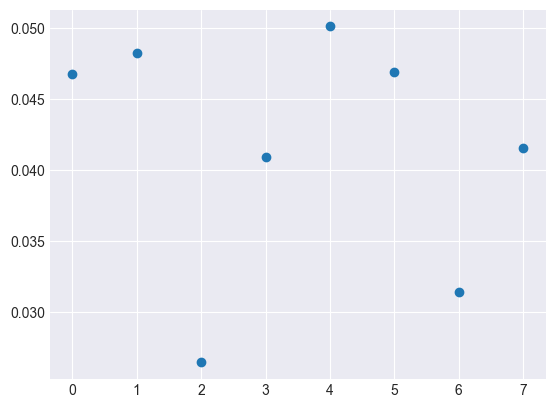

In [8]:
# testing different ways to get NSA parameters, specifically redshift z

images3 = marvin.utils.general.images.get_random_images(10)
test = []

for item in images3:
    #print(item.__dict__)
    ifu = item.plateifu

    try:
        cube = Cube(plateifu = ifu)
        print(ifu, cube.nsa['z'])
        test.append(cube.nsa['z'])

    except:
        print(f"No cube for {ifu}")

xaxis = np.arange(0, len(test), 1)
plt.scatter(xaxis, test)

In [4]:
# the above method is slow and inefficient and sometimes fails completely when it finds a galaxy that lacks NSA params
# Query is much faster:

from marvin.tools.query import Query

my_filter = 'nsa.z < 0.05'
q = Query(search_filter=my_filter)
print(q)

# run the query
r = q.run()

# print some results information
print(r)
print('number of results:', r.totalcount)

Marvin Query(filter='nsa.z < 0.05', mode='remote', data_origin='api')
Marvin Results(query=nsa.z < 0.05, totalcount=7151, count=100, mode=remote)
number of results: 7151


Easy First Step: Rotation Curve
Steps:
1. Import units and constants
2. Seach for galaxies, start with a filter where the inclination angle ~ 0 degrees to our viewing plane
3. Get a stellar velocity dispersion map for every such galaxy
4. Calculate mass from the velocities

In [31]:
# using previous work (STARS final project) as hints

from astropy import constants as C
from astropy import units as u
from marvin.tools.query import Query
from marvin.tools import Maps

elpetro_ba is the b/a ratio. a high b/a (close to 1) means that the galaxy is close to perfectly face-on, while a low b/a (close to 0) means that the galaxy is perfectly edge-on

In [5]:
my_filter = 'nsa.elpetro_ba < 0.17'
q = Query(search_filter=my_filter)
print(q)

# run the query
r = q.run()

# print some results information
print('number of results:', r.totalcount)

Marvin Query(filter='nsa.elpetro_ba < 0.17', mode='remote', data_origin='api')
number of results: 3


In [32]:
q = Query(search_filter='nsa.sersic_logmass > 0') 
results = q.run()
    
# Get the total count of results
total_count = results.totalcount
print(total_count)

10226


In [33]:
from marvin.tools.query import Query
from marvin.utils.datamodel.query.base import query_params

#query_params.list_params()

query = Query(search_filter='nsa.sersic_logmass > 0', limit = total_count)
results = query.run()

sersic_logmass = []

for i in range(total_count):
    #print(i, results.results[i][2])
    sersic_logmass.append(results.results[i][2])

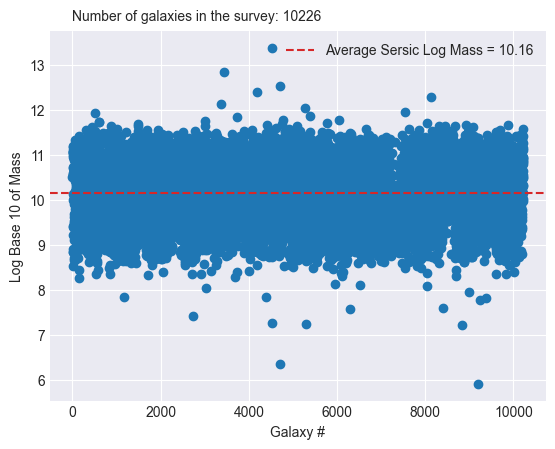

In [34]:
test = np.arange(1, len(sersic_logmass)+1, 1)

avg_logmass = (np.sum(sersic_logmass) / len(sersic_logmass))

fig, ax = plt.subplots()
ax.scatter(test, sersic_logmass)
ax.set_xlabel("Galaxy #")
ax.set_ylabel("Log Base 10 of Mass")
plt.axhline(y=avg_logmass, color='tab:red', linestyle='--', label= f'Average Sersic Log Mass = {avg_logmass:.2f}')
plt.text(0.5, 14, f"Number of galaxies in the survey: {len(sersic_logmass)}")
ax.legend()
plt.show()